cuda:0


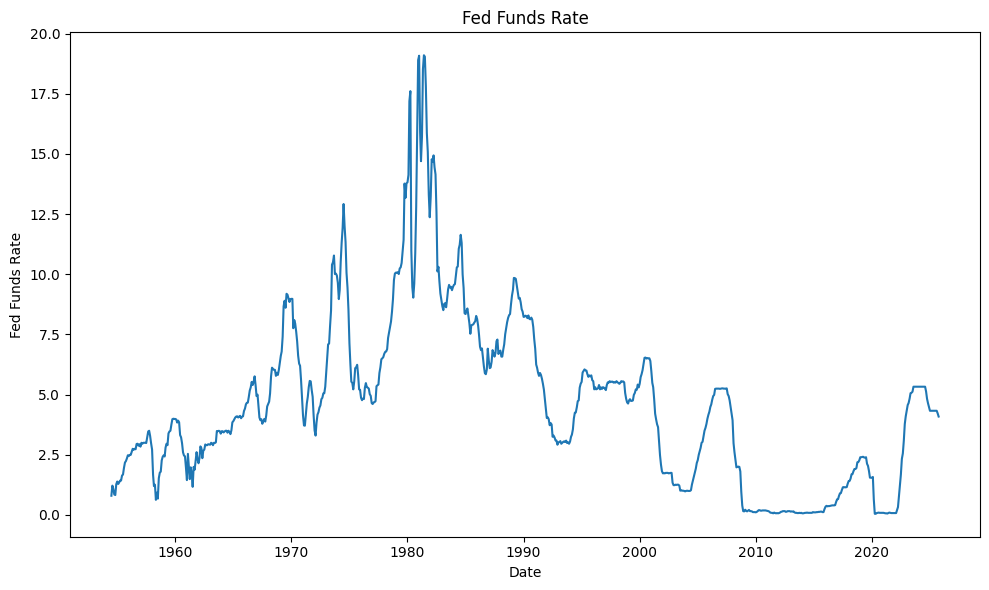

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import fredapi.fred as fr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_percentage_error
from dotenv import load_dotenv
import os
load_dotenv()
FRED_API_KEY = os.getenv("FRED_API_KEY")


fred = fr.Fred(FRED_API_KEY)




device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

# fed funds rate

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()
data = data.reset_index()
data['Date'] = data['index']


data.drop("index",axis=1,inplace=True)


plt.figure(figsize=(10,6))
sns.lineplot(x=data['Date'],y=data['Fed Funds Rate'])
plt.title("Fed Funds Rate")
plt.tight_layout()
plt.show()


In [2]:
data.head(10)

,Fed Funds Rate,Date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01
5,1.28,1954-12-01
6,1.39,1955-01-01
7,1.29,1955-02-01
8,1.35,1955-03-01
9,1.43,1955-04-01


In [3]:
#training
training = data.iloc[:,0:1].values



train_split = int(len(training) * .80)
train_data = training[:train_split]
test_data = training[train_split:]
print(f' Shape of training data: {train_data.shape}')
print(f' Shape of testing data: {test_data.shape}')

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(dataframe, seq_length):
    X, y = [], []
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(i + seq_length)]
        yi = dataframe[i + seq_length]
        X.append(Xi)
        y.append(yi)
    return np.array(X), np.array(y)

seq_length = 14

X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()



class BiLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, output_size=1):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X,(h0, c0))
        out = self.fc(out[:,-1,:])
        return out



bidirectional_lstm = BiLSTM()
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

 Shape of training data: (684, 1)
 Shape of testing data: (172, 1)


In [4]:
for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RMSE: {train_rmse:.4}; Test RMSE: {test_rmse:.4}')
        

/tmp/ipykernel_20639/1334293925.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_20639/1334293925.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RMSE: 0.2621; Test RMSE: 0.0984
Epoch: 1; train_RMSE: 0.2012; Test RMSE: 0.1406
Epoch: 2; train_RMSE: 0.1757; Test RMSE: 0.2392
Epoch: 3; train_RMSE: 0.2122; Test RMSE: 0.3286
Epoch: 4; train_RMSE: 0.1962; Test RMSE: 0.3022
Epoch: 5; train_RMSE: 0.1738; Test RMSE: 0.2518
Epoch: 6; train_RMSE: 0.1663; Test RMSE: 0.2091
Epoch: 7; train_RMSE: 0.1682; Test RMSE: 0.1796
Epoch: 8; train_RMSE: 0.1715; Test RMSE: 0.1617
Epoch: 9; train_RMSE: 0.1725; Test RMSE: 0.1525
Epoch: 10; train_RMSE: 0.1702; Test RMSE: 0.1501
Epoch: 11; train_RMSE: 0.1648; Test RMSE: 0.1528
Epoch: 12; train_RMSE: 0.1575; Test RMSE: 0.1601
Epoch: 13; train_RMSE: 0.1498; Test RMSE: 0.1712
Epoch: 14; train_RMSE: 0.1436; Test RMSE: 0.1851
Epoch: 15; train_RMSE: 0.1409; Test RMSE: 0.1996
Epoch: 16; train_RMSE: 0.141; Test RMSE: 0.2099
Epoch: 17; train_RMSE: 0.139; Test RMSE: 0.2097
Epoch: 18; train_RMSE: 0.1308; Test RMSE: 0.1964
Epoch: 19; train_RMSE: 0.1181; Test RMSE: 0.1727
Epoch: 20; train_RMSE: 0.1062; T

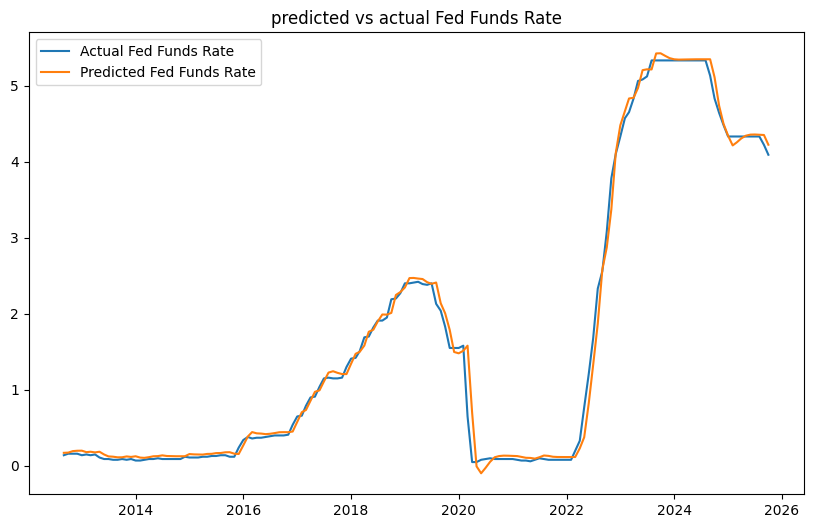

In [5]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)




test_dates = data.iloc[train_split + seq_length:]['Date']

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Fed Funds Rate": actual_rescaled.flatten(),
    "Predicted Fed Funds Rate":pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Fed Funds Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Fed Funds Rate'],label="Predicted Fed Funds Rate")
plt.title("predicted vs actual Fed Funds Rate")
plt.legend()
plt.show()

In [6]:
# Root Mean-Squared Error
rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f'Root Mean-Squared Error: {rmse:.4f}')

# R2 Score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f'R2 Score: {r2*100:.2f}%')

# mean absolute percentage error
mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f'Mean Absolute Percentage Error: {mape:.4f}')




print(comparison_df.head(20))
print(comparison_df.tail(20))

Root Mean-Squared Error: 0.1373
R2 Score: 99.46%
Mean Absolute Percentage Error: 0.3064
          Date  Actual Fed Funds Rate  Predicted Fed Funds Rate
698 2012-09-01                   0.14                  0.171573
699 2012-10-01                   0.16                  0.174369
700 2012-11-01                   0.16                  0.194182
701 2012-12-01                   0.16                  0.198863
702 2013-01-01                   0.14                  0.199886
703 2013-02-01                   0.15                  0.180468
704 2013-03-01                   0.14                  0.185792
705 2013-04-01                   0.15                  0.177369
706 2013-05-01                   0.11                  0.185806
707 2013-06-01                   0.09                  0.149824
708 2013-07-01                   0.09                  0.124504
709 2013-08-01                   0.08                  0.120644
710 2013-09-01                   0.08                  0.112486
711 2013-10-01  